In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2016-08-01', '2017-08-01'))

[(58.0, 74.64288840262581, 87.0)]


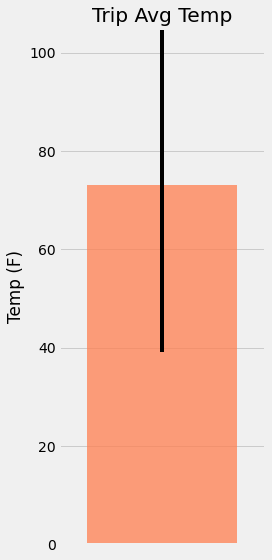

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

results = session.query(Measurement.date, Measurement.tobs).all()
temp_df = pd.DataFrame(results, columns=["Date", "Temperature (F)"])
#temp_df.head()
avg_temp = temp_df['Temperature (F)'].mean()
tmax = temp_df['Temperature (F)'].max()
tmin = temp_df['Temperature (F)'].min()
# tmax = 87, tmin = 53, avg_temp = 73.1

xpos = 1


plt.figure(figsize=(4, 8))
plt.bar(xpos, avg_temp, yerr=tmax-tmin, alpha=0.75, color="coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)
plt.savefig("../Images/temperature_fh.png")


### Daily Rainfall Average

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
start_date = '2016-08-01'
end_date = '2016-08-07'

rain_per_station =(
    session.query(
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.avg(Measurement.prcp)
    )
    .filter(Measurement.station == Station.station,Measurement.date.between(start_date, end_date),
           )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc()).all()
)
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_per_station_df = pd.DataFrame(np.array(rain_per_station))
rain_per_station_df = rain_per_station_df.rename(
    columns={
        0: "Station",
        1: "Name",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Average Precipitation",
    }
)
rain_per_station_df

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)


# Strip off the year and save a list of strings in the format %m-%d
date_list = [d.strftime("%m-%d") for d in trip_dates]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
from pprint import pprint
daily_normal = [daily_normals(d)[0] for d in date_list]
pprint(daily_normal)

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(daily_normal, columns=['TMIN', 'TAVG', 'TMAX'],index=trip_dates)
daily_normals_df.index.name = 'Date'
daily_normals_df

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(10, 8))
plt.title(f"Temperature Records for Trip Dates\n {start_date} to {end_date}")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.savefig("../Images/daily_normals_fh.png")

## Close Session

In [ ]:
session.close()